In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import missingno as msno
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import ExtraTreeRegressor

In [6]:
train = pd.read_csv("data/km_train_extra_v2.csv", encoding='utf-8', sep=',')

test = pd.read_csv("data/km_test_extra_v2.csv", encoding='utf-8', sep=',')

In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolAreaYes,MiscValYes,YrSoldDiff,kn_8,kn_16,kn_32,kn_64,kn_128,kn_256,kn_512
0,1,60,3,0.212898,-0.205996,1,1,3,3,0,...,0,0,3,1,2,5,26,45,24,42
1,2,20,3,0.645875,-0.090876,1,1,3,3,0,...,0,0,4,5,15,18,47,54,73,281
2,3,60,3,0.299493,0.074297,1,1,0,3,0,...,0,0,3,1,2,5,26,45,24,321
3,4,70,3,0.068572,-0.095881,1,1,0,3,0,...,0,0,5,4,7,22,10,78,211,146
4,5,60,3,0.761335,0.375612,1,1,0,3,0,...,0,0,3,1,2,5,52,2,3,484


In [8]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolAreaYes,MiscValYes,YrSoldDiff,kn_8,kn_16,kn_32,kn_64,kn_128,kn_256,kn_512
0,1461,20,2,0.684849,0.363929,1,1,3,3,0,...,0,0,1,5,8,10,29,0,160,509
1,1462,20,3,0.715852,0.897861,1,1,0,3,0,...,0,1,1,5,8,10,29,0,160,397
2,1463,60,3,0.498831,0.809646,1,1,0,3,0,...,0,0,1,1,2,12,52,62,105,212
3,1464,60,3,0.622843,0.032064,1,1,0,3,0,...,0,0,1,1,2,12,52,62,105,212
4,1465,120,3,-0.462261,-0.971808,1,1,0,1,0,...,0,0,1,6,4,27,49,67,115,242


In [9]:
X = train.loc[:,train.columns != 'Id']
X = X.loc[:,X.columns != 'SalePrice']
y = train['SalePrice']

In [10]:
xgbr = XGBRegressor()

In [11]:
xgbr.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

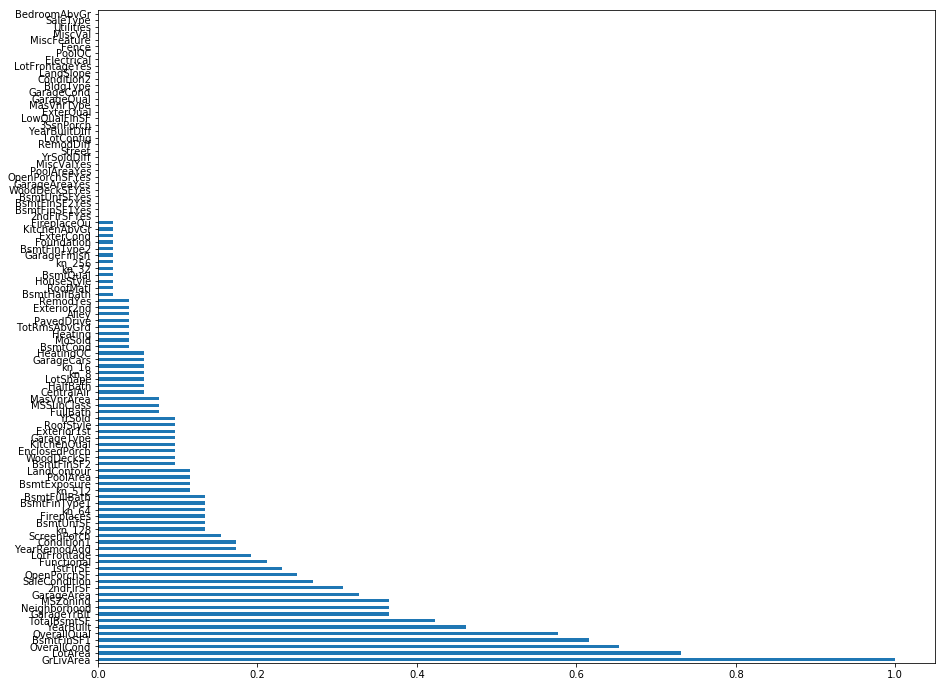

In [12]:
feat_importances_xgb = pd.Series(xgbr.feature_importances_/xgbr.feature_importances_.max(), index=X.columns)
feat_importances_xgb = feat_importances_xgb.nlargest(X.shape[1])
feat_importances_xgb.plot(kind='barh', figsize=((15,12)))

In [13]:
lgb_train = lgb.Dataset(X, y)
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=2000)

Start training...


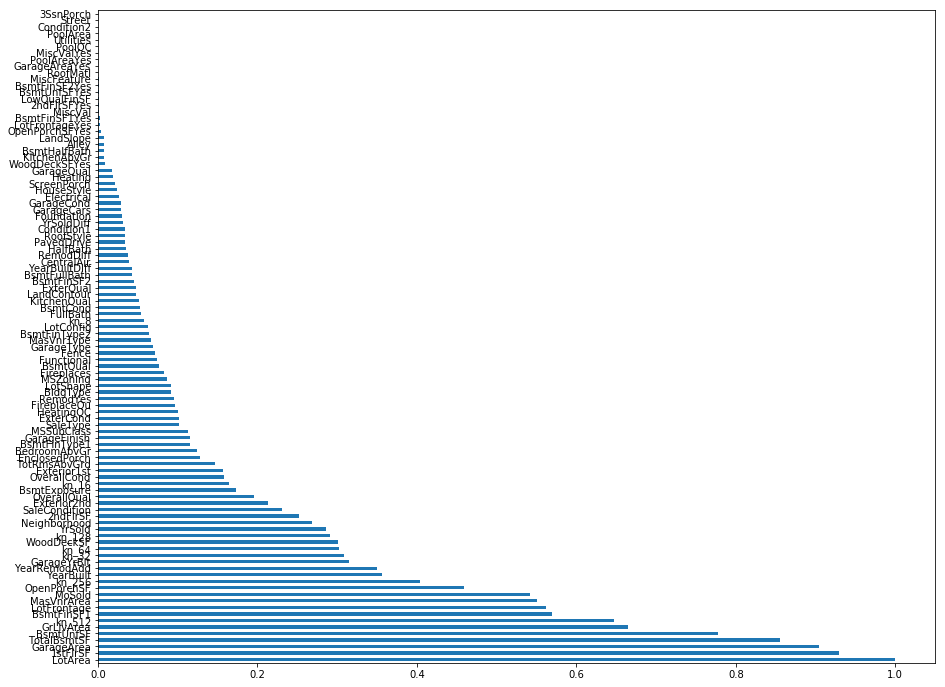

In [14]:
feat_importances_gbm = pd.Series((gbm.feature_importance()/gbm.feature_importance().max()), index=X.columns)
feat_importances_gbm = feat_importances_gbm.nlargest(X.shape[1])
feat_importances_gbm.plot(kind='barh', figsize=((15,12)))

In [15]:
rfr = RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [16]:
rfr.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

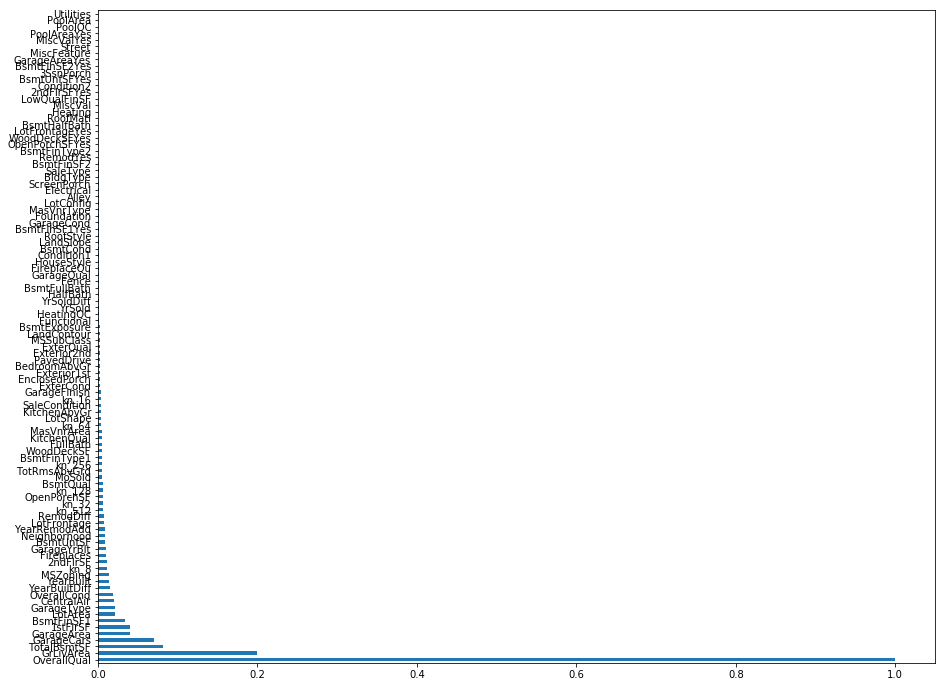

In [17]:
feat_importances_rfr = pd.Series(rfr.feature_importances_/rfr.feature_importances_.max(), index=X.columns)
feat_importances_rfr = feat_importances_rfr.nlargest(X.shape[1])
feat_importances_rfr.plot(kind='barh', figsize=((15,12)))

In [18]:
gbr = GradientBoostingRegressor(learning_rate=0.05,
                               max_depth=20,
                               n_estimators=500,
                               subsample=0.5,
                               )

In [19]:
gbr.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=20,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=0.5, verbose=0, warm_start=False)

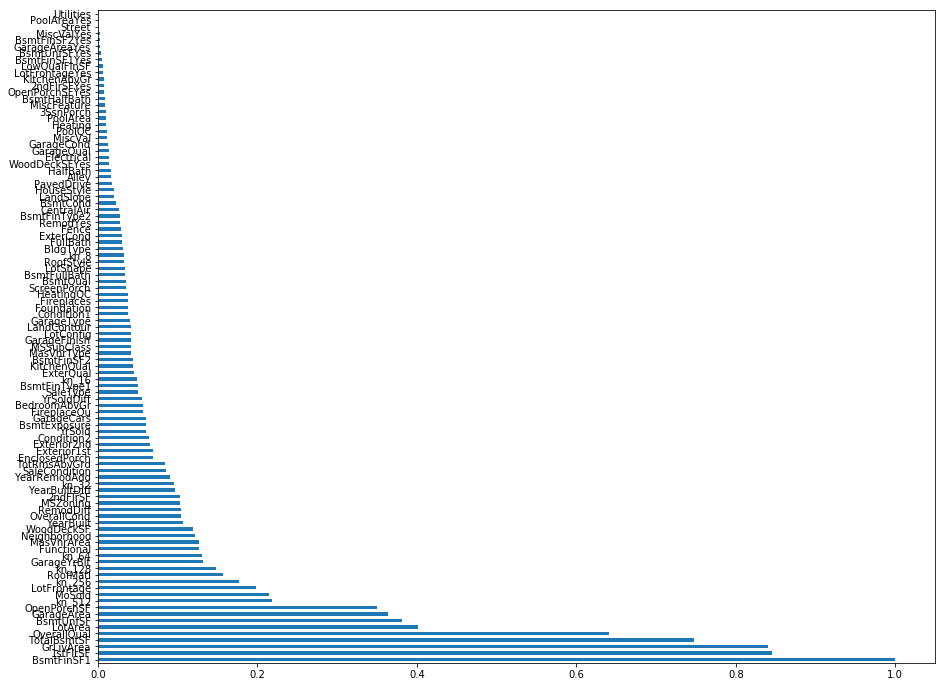

In [20]:
feat_importances_gbr = pd.Series(gbr.feature_importances_/gbr.feature_importances_.max(), index=X.columns)
feat_importances_gbr = feat_importances_gbr.nlargest(X.shape[1])
feat_importances_gbr.plot(kind='barh', figsize=((15,12)))

In [21]:
etr = ExtraTreeRegressor(max_depth=30,
                        )

In [22]:
etr.fit(X,y)

ExtraTreeRegressor(criterion='mse', max_depth=30, max_features='auto',
          max_leaf_nodes=None, min_impurity_split=1e-07,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')

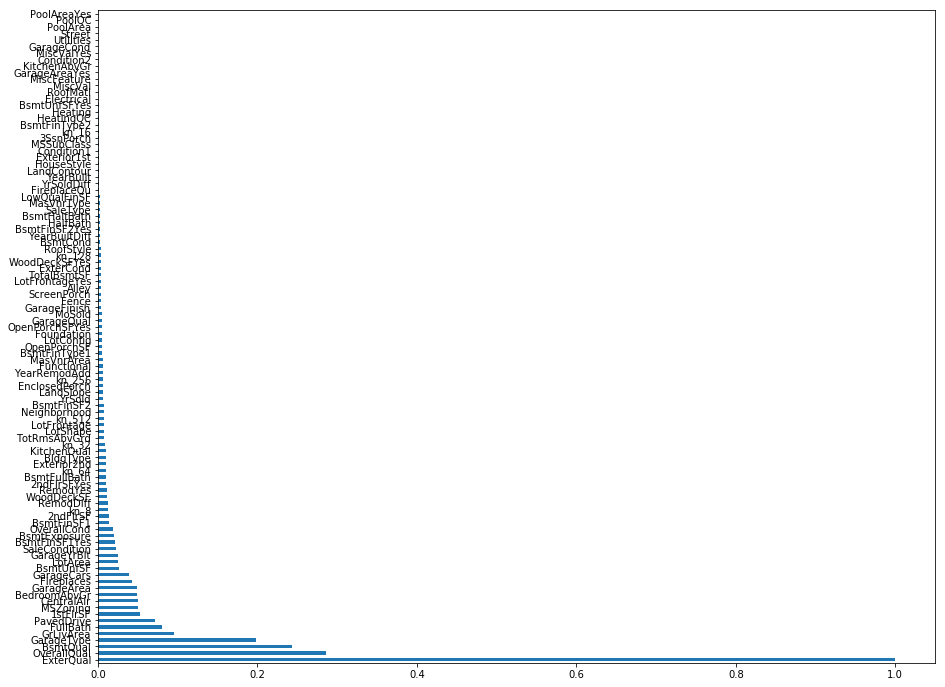

In [23]:
feat_importances_etr = pd.Series(etr.feature_importances_/etr.feature_importances_.max(), index=X.columns)
feat_importances_etr = feat_importances_etr.nlargest(X.shape[1])
feat_importances_etr.plot(kind='barh', figsize=((15,12)))

In [24]:
names = list()
suma = list()
for col in train.columns:
    try:
        suma.append(feat_importances_rfr[col]+ \
                    feat_importances_gbm[col]+ \
                    feat_importances_xgb[col]+ \
                   feat_importances_etr[col] + \
                   feat_importances_gbr[col])
        names.append(col)
    except:
        print('|{}| do not exist this column in features importances'.format(col))
    
IMPORTANCES = pd.DataFrame({'ft': names, 'rel_importance': suma/(max(suma))})
IMPORTANCES = IMPORTANCES.sort_values(by = 'rel_importance', ascending=False)

|Id| do not exist this column in features importances
|SalePrice| do not exist this column in features importances


In [25]:
CUM_SUM = IMPORTANCES['rel_importance'].\
sort_values(ascending=True).cumsum()/max(IMPORTANCES['rel_importance'].\
                                         sort_values(ascending=True).cumsum())

In [26]:
# pd.Series(IMPORTANCES['rel_importance'].values,
#                     index = IMPORTANCES['ft'])

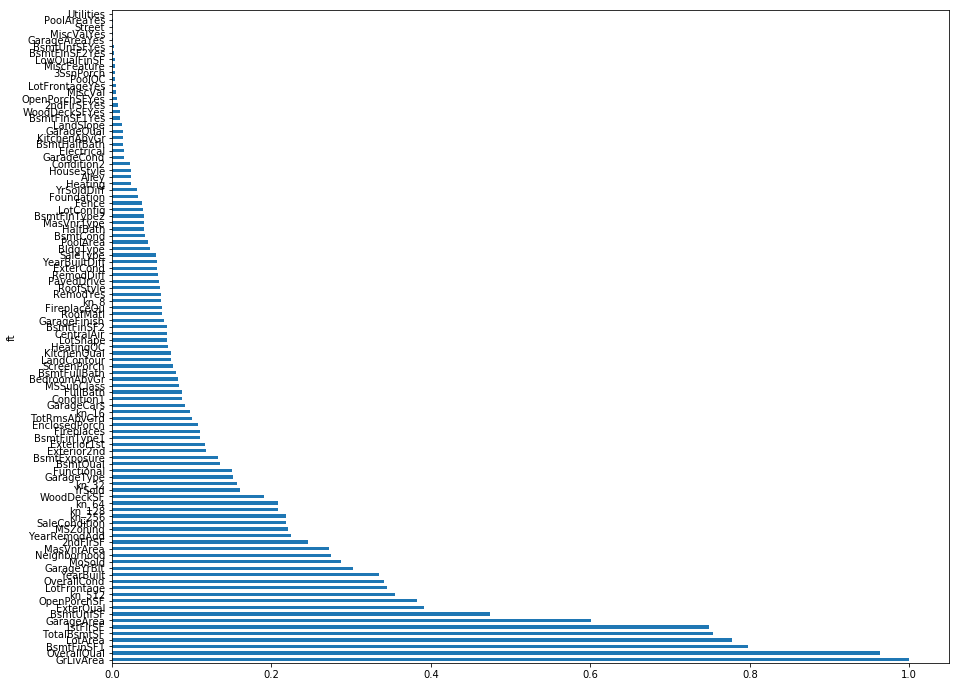

In [27]:
# feat_importances_xgb = pd.Series(xgbr.feature_importances_/xgbr.feature_importances_.max(), index=X.columns)
# feat_importances_xgb = feat_importances_xgb.nlargest(X.shape[1])
# feat_importances_xgb.plot(kind='barh', figsize=((15,12)))

imp_plot = pd.Series(IMPORTANCES['rel_importance'].values,
                    index = IMPORTANCES['ft'])
imp_plot = imp_plot.nlargest(IMPORTANCES.shape[0])
imp_plot.plot(kind='barh', figsize=((15,12)))

In [56]:
list_importance = imp_plot.index[:50].tolist()
list_importance

['GrLivArea',
 'OverallQual',
 'BsmtFinSF1',
 'LotArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'GarageArea',
 'BsmtUnfSF',
 'ExterQual',
 'OpenPorchSF',
 'kn_512',
 'LotFrontage',
 'OverallCond',
 'YearBuilt',
 'GarageYrBlt',
 'MoSold',
 'Neighborhood',
 'MasVnrArea',
 '2ndFlrSF',
 'YearRemodAdd',
 'MSZoning',
 'SaleCondition',
 'kn_256',
 'kn_128',
 'kn_64',
 'WoodDeckSF',
 'YrSold',
 'kn_32',
 'GarageType',
 'Functional',
 'BsmtQual',
 'BsmtExposure',
 'Exterior2nd',
 'Exterior1st',
 'BsmtFinType1',
 'Fireplaces',
 'EnclosedPorch',
 'TotRmsAbvGrd',
 'kn_16',
 'GarageCars',
 'Condition1',
 'FullBath',
 'MSSubClass',
 'BedroomAbvGr',
 'BsmtFullBath',
 'ScreenPorch',
 'LandContour',
 'KitchenQual',
 'HeatingQC',
 'LotShape']

In [57]:
list_importance.append('Id')

In [58]:
test = test.loc[:,list_importance]

In [59]:
list_importance.append('SalePrice')

In [60]:
train = train.loc[:,list_importance]

In [61]:
train.shape, test.shape

((1451, 52), (1459, 51))

In [62]:
train.to_csv('data/train_ft_sel_50_v2.csv', sep = ',', index = False)

test.to_csv('data/test_ft_sel_50_v2.csv', sep = ',', index = False)